In [1]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import trange

from utils import EWC, test, train, PermutedMNIST

In [2]:
epochs = 75
lr = 1e-3
batch_size = 128
sample_size = 200
hidden_size = 200
num_task = 3
importance = 1000

In [3]:
class MLP(nn.Module):
    def __init__(self, hidden_size: int = 400):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 10),
            nn.ReLU(inplace=True),
        )

    def forward(self, input):
        return self.layers(input)

In [4]:
train_loader: dict[int, DataLoader] = {}
test_dataset: dict[int, PermutedMNIST] = {}

for i in range(num_task):
    idx = torch.randperm(28 * 28)
    train_loader[i] = DataLoader(
        PermutedMNIST(train=True, permute_idx=idx),
        batch_size,
        num_workers=8,
        persistent_workers=True,
    )
    test_dataset[i] = PermutedMNIST(train=False, permute_idx=idx)

In [5]:
def process(epochs: int, use_ewc: bool):
    model = MLP(hidden_size).cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)

    losses: list[list[float]] = [[] for _ in range(num_task)]
    accs: list[list[float]] = [[] for _ in range(num_task)]

    for training_task in range(num_task):
        if use_ewc and training_task != 0:
            old_tasks = []
            for trained_task in range(training_task):
                dataset = train_loader[trained_task].dataset
                assert isinstance(dataset, PermutedMNIST)
                old_tasks += dataset.get_sample(sample_size // training_task)
            ewc = EWC(model, torch.vstack(old_tasks))
        else:
            ewc = None

        for _ in trange((2 if training_task == 0 else 1) * epochs):
            train(
                model,
                optimizer,
                train_loader[training_task],
                ewc,
                importance,
            )

            for task in range(num_task):
                loss, acc = test(model, test_dataset[task])
                accs[task].append(acc)
                losses[task].append(loss)

    return losses, accs

In [6]:
def plot(losses: list[list[float]], accs: list[list[float]]):
    fig, ax = plt.subplots(2, figsize=(5, 6), sharex=True)
    for task, loss in enumerate(losses):
        ax[0].plot(loss, label=f"Task {task}")
    for task, acc in enumerate(accs):
        ax[1].plot(acc, label=f"Task {task}")
    ax[0].set(ylabel="Loss")
    ax[1].set(ylabel="Accuracy", ylim=(0, 1), xlabel="Epochs")
    ax[0].legend()
    ax[1].grid(color="gray", linestyle=":")
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    fig.tight_layout()

In [29]:
loss, acc = process(epochs, use_ewc=False)

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:49<00:00,  1.52it/s]


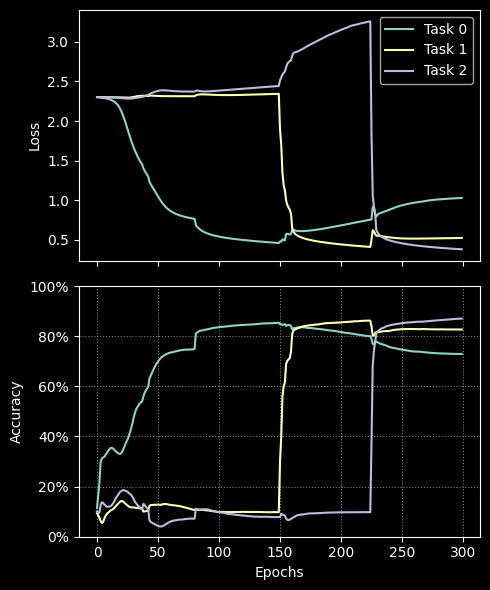

In [30]:
plot(loss, acc)

In [9]:
loss_ewc, acc_ewc = process(epochs, use_ewc=True)

100%|██████████| 75/75 [01:18<00:00,  1.05s/it]


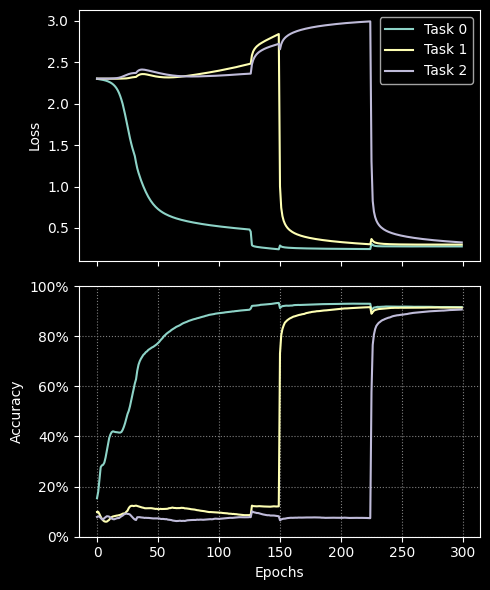

In [10]:
plot(loss_ewc, acc_ewc)

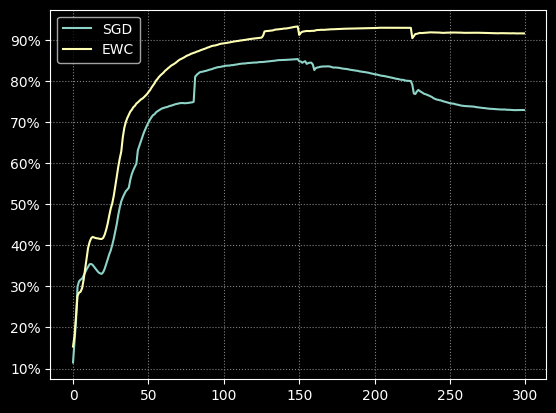

In [31]:
fig, ax = plt.subplots()
ax.plot(acc[0], label="SGD")
ax.plot(acc_ewc[0], label="EWC")
ax.grid(color="gray", linestyle=":")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.legend()